# Actuator Line Post Processing Notebook 
Markella Zormpa, August 2022

This notebook contains the main post processing to be performed after every AL-LES simulation. That is:
## Convergence
    1. Residuals
    2. Power and thrust
    3. Probes of instantaneous velocity
    4. Probes of mean velocity 
    5. Probes of Reynolds stresses
    
## Rotor Information 
    1. CP & CT
    2. Spanwise distributions
    
## Power Spectral Density 

------------------------------------------------------------------------------------------------------------------
                                                  .--.
                                                .'_\/_'.
                                                '. /\ .'
                                                  "||"
                                                   || /\
                                                /\ ||//\)
                                               (/\\||/
                                          ________\||/________

# Initializations

In [3]:
from os.path import join
from re import sub
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch
from IPython.display import Image
from IPython.display import HTML, display
import matplotlib.image as image
import linecache
import csv
import subprocess
import os
plt.rcParams["figure.dpi"] = 180

In [4]:
# User input
pwd = '/data/engs-windfarm-cfd/ball5392/exampleCasePHD_final'
nbLastPeriods = 1           # how many periods to average over to calculate Pmean and Tmean for CP,CT
probe_ids = [7, 8, 13, 14]  # Probe IDs to plot
period = 0.0463             # rotating period in s 
rho = 1.225                 # density in kg/m^3
U = 10                      # inflow velocity (used for cp,ct) in m/s
D = 0.894                     # diameter in m 

# Switches
probes_Inst = 1
probes_Stat = 1
solverInfo = 1
turbineOutput = 1

# Read from foam files 
# rotSpeed = float(subprocess.getoutput("grep 'RotSpeed' constant/turbineArrayProperties  | cut -f1 -d';' | awk '{print $2}'"))
# turbineType =  subprocess.getoutput("grep 'turbineType' constant/turbineArrayProperties  | cut -f1 -d';' | awk '{print $2}' ")
# turbineType = print(turbineType[1:-1])

# Convergence
### 1) Residuals

Last Ux value:  0.000104482619
Last Uy value:  0.0010005404
Last Uz value:  0.00115664119
Last p value:   0.0666758142


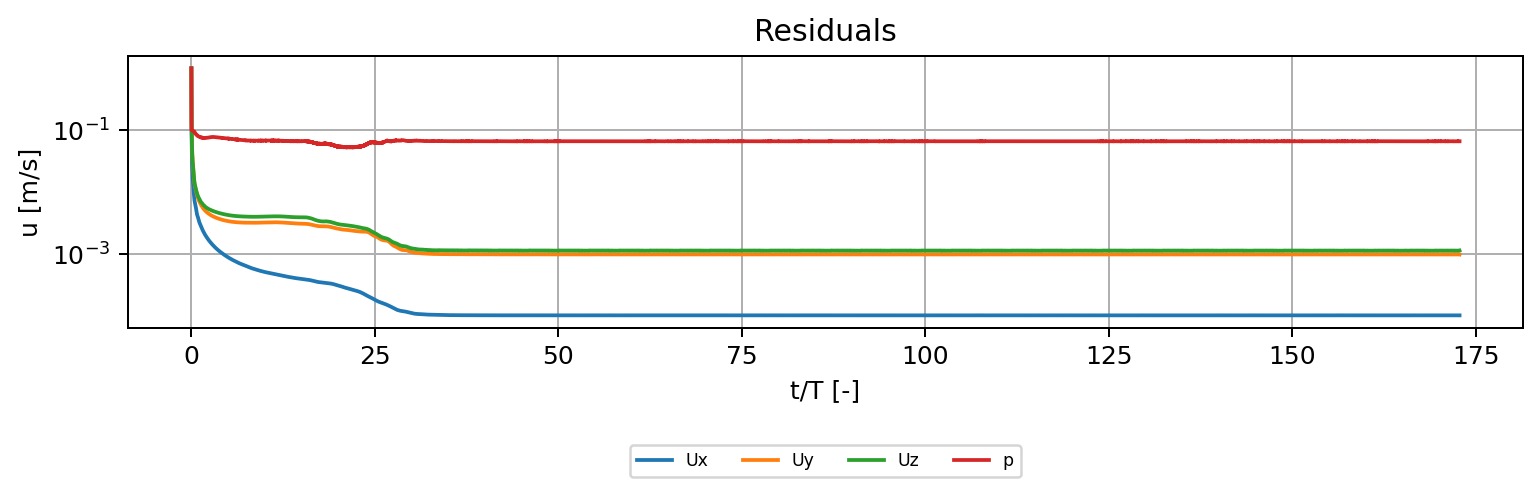

In [5]:
if solverInfo:
    restartTimes = sorted(os.listdir(pwd+'/postProcessing/solverInfo'))
    solverInfo_path = [pwd+"/postProcessing/solverInfo/"+s for s in restartTimes]
    # stack residuals for different times
    with open(join(solverInfo_path[0], "solverInfo.dat"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)

    all_residuals = np.array(data)

    for file in solverInfo_path[1:]:
        with open(join(file, "solverInfo.dat"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
            all_residuals = np.vstack((all_residuals,data))
    del data
    
    i_coor = 0            ## definition of what coordinate I want to print
    fig, ax = plt.subplots()
    plt.title("Residuals")
    ax.plot(all_residuals[:,0]/period,all_residuals[:,2],label="Ux")
    ax.plot(all_residuals[:,0]/period,all_residuals[:,5],label="Uy")
    ax.plot(all_residuals[:,0]/period,all_residuals[:,8],label="Uz")
    ax.plot(all_residuals[:,0]/period,all_residuals[:,13],label="p")
    ax.set_yscale('log')
    legend = ax.legend(loc='upper center', fontsize='x-small',bbox_to_anchor = [0.5,-0.4],ncol=4)
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('u [m/s]')
    plt.grid()
    print('Last Ux value: ',all_residuals[-1,2])
    print('Last Uy value: ',all_residuals[-1,5])
    print('Last Uz value: ',all_residuals[-1,8])
    print('Last p value:  ',all_residuals[-1,13])

### 2) Power and thrust

Time steps per period:       98
Number of periods available: 172


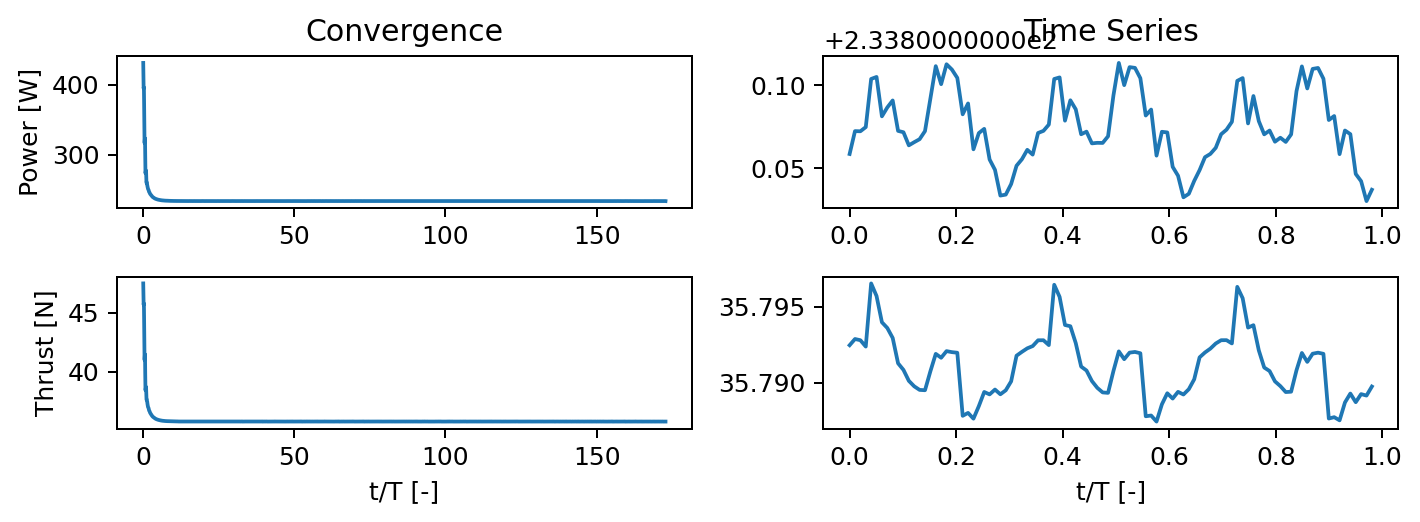

In [6]:
if turbineOutput:
    restartTimes = sorted(os.listdir(pwd+'/turbineOutput'))
    turbine_output_path = [pwd+"/turbineOutput/"+s for s in restartTimes]
    
    # power
    power_data = [None,None,None,None]
    for file in turbine_output_path:
        with open(join(file,"powerRotor"), "r") as pfile:
            data = read_csv(StringIO(pfile.read()),header=None, comment="#", delim_whitespace=True)
            power_data = np.vstack((power_data,data))
            del data
    power_data = np.delete(power_data, (0), axis=0)
    dt = power_data[1,2]
    dtPerPeriod = int(period/dt)
    print('Time steps per period:      ', dtPerPeriod)
    print('Number of periods available:',int((power_data[-1,1]-power_data[0,1])/period))
    nRows = power_data.shape[0]
    power_lastPer = power_data[-int(dtPerPeriod*nbLastPeriods):nRows]

    # thrust
    thrust_data = [None,None,None,None]
    for file in turbine_output_path:
        with open(join(file,"thrust"), "r") as pfile:
            data = read_csv(StringIO(pfile.read()),header=None, comment="#", delim_whitespace=True)
            thrust_data = np.vstack((thrust_data,data))
            del data
    thrust_data = np.delete(thrust_data, (0), axis=0)
    dt = thrust_data[1,2]
    dtPerPeriod = period/dt
    nRows = thrust_data.shape[0]
    thrust_lastPer = thrust_data[-int(dtPerPeriod*nbLastPeriods):nRows]
    
    # plot power and thrust
    fig, ax = plt.subplots(2, 2, figsize=(8, 3), sharex=False, sharey=False)
    ax[0,0].plot(power_data[:,1]/period, power_data[:,3])
    ax[0,0].set_ylabel('Power [W]')
    ax[0,0].title.set_text('Convergence')
    ax[0,1].plot((power_lastPer[:,1]-power_lastPer[0,1])/period, power_lastPer[:,3])
    ax[0,1].title.set_text('Time Series')
    ax[1,0].plot(thrust_data[:,1]/period, thrust_data[:,3])
    ax[1,0].set_ylabel('Thrust [N]')
    ax[1,0].set_xlabel('t/T [-]')
    ax[1,1].plot((thrust_lastPer[:,1]-thrust_lastPer[0,1])/period, thrust_lastPer[:,3])
    ax[1,1].set_xlabel('t/T [-]')
    fig.tight_layout()

### 3) Instantaneous velocity

 Time series eliminated from 17094 to 17094


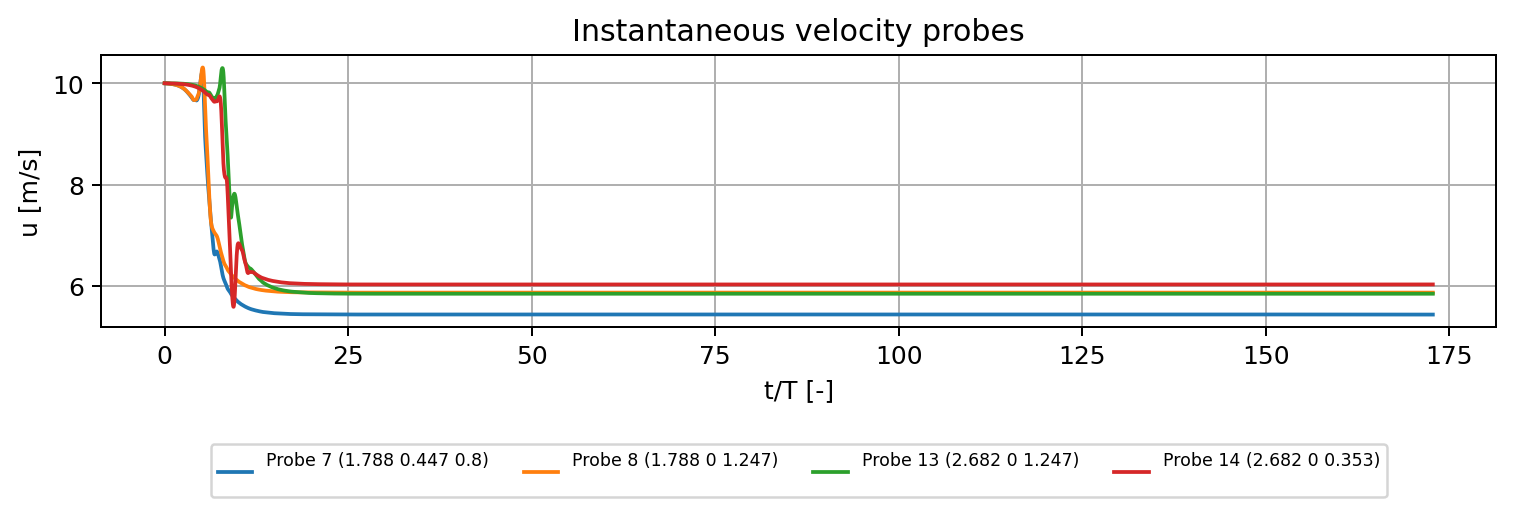

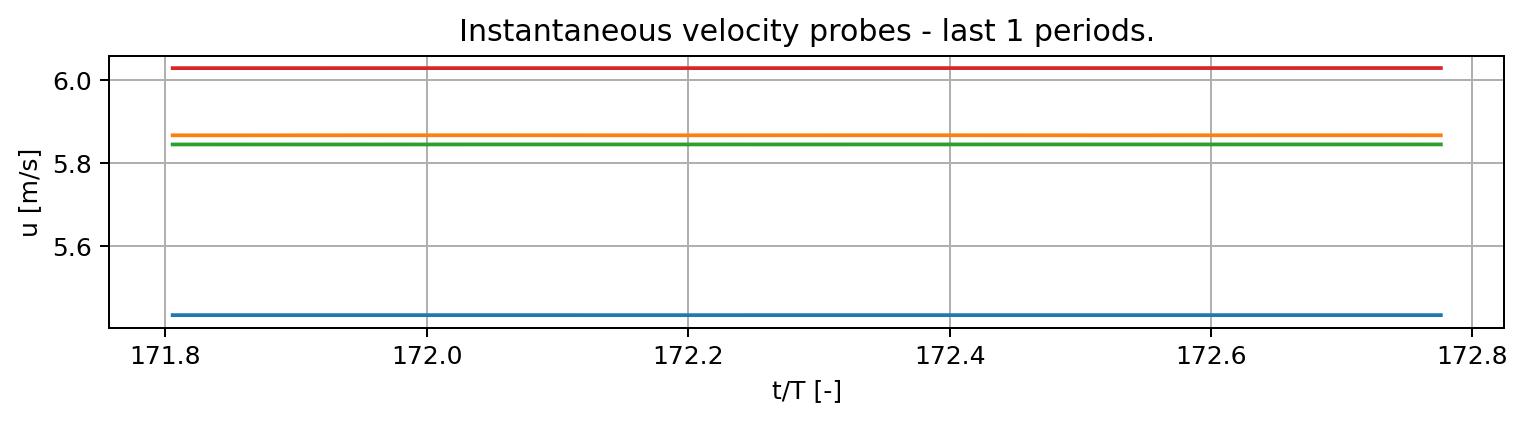

In [7]:
if probes_Inst:
    restartTimes = sorted(os.listdir(pwd+'/turbineOutput'))
    probes_U_p_path = [pwd+"/postProcessing/probesInst/"+s for s in restartTimes]
    
    # probe names
    probe_names = []
    import linecache
    for probe_id in probe_ids:
        a = linecache.getline(join(probes_U_p_path[0], "U"), probe_id+1)
        probe_names.append(a[2:])

    # stack probe data for different times
    with open(join(probes_U_p_path[0], "U"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
    all_probes = np.array(data)
    for file in probes_U_p_path[1:]:
        with open(join(file, "U"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
            all_probes = np.vstack((all_probes,data))
    del data

    # remove non unique rows
    _ , index = np.unique(all_probes[:,0], return_index=True,axis=0)
    all_probes_unique = all_probes[index,:]
    initial_size = len(all_probes)
    unique_size = len(all_probes_unique)
    print (" Time series eliminated from",initial_size, "to",unique_size)
    del all_probes

    # plot probes
    i_coor = 0                          ## definition of what coordinate I want to print
    fig, ax = plt.subplots()
    plt.title("Instantaneous velocity probes")
    for index, elem in enumerate(probe_ids):
        ax.plot(all_probes_unique[:,0]/period,all_probes_unique[:,1+3*probe_ids[index]+i_coor],label=probe_names[index])
    legend = ax.legend(loc='upper center', fontsize='x-small',bbox_to_anchor = [0.5,-0.4],ncol=index+1)
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('u [m/s]')
    plt.grid()
    
    # plot probes zoom in
    fig, ax = plt.subplots()
    plt.title("Instantaneous velocity probes - last %i periods." %nbLastPeriods)
    for index, elem in enumerate(probe_ids):
        count = 1+3*probe_ids[index]+i_coor
        ax.plot(all_probes_unique[-int(dtPerPeriod*nbLastPeriods):-1,0]/period,all_probes_unique[-int(dtPerPeriod*nbLastPeriods):-1,count],label=probe_names[index])
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('u [m/s]')
    plt.grid()
    
    # rename some instantaneous data to use later
    all_u_inst = all_probes_unique.copy()    
    del all_probes_unique
    

### 4) Mean velocity

 Time series eliminated from 13095 to 13095


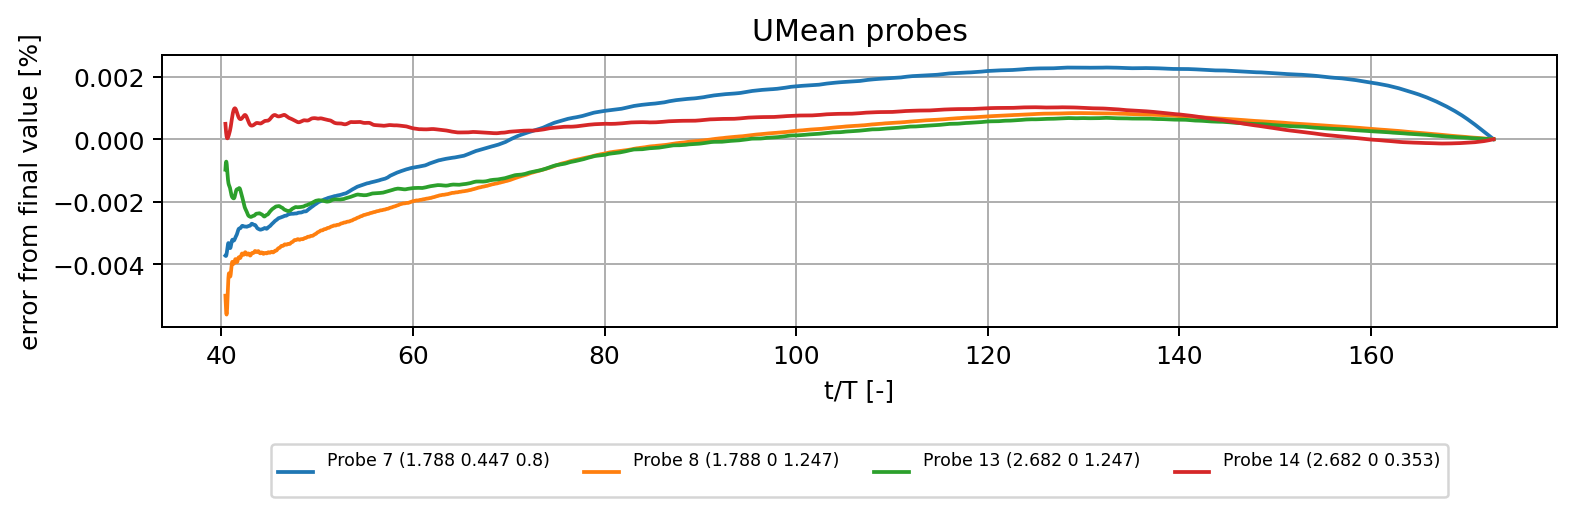

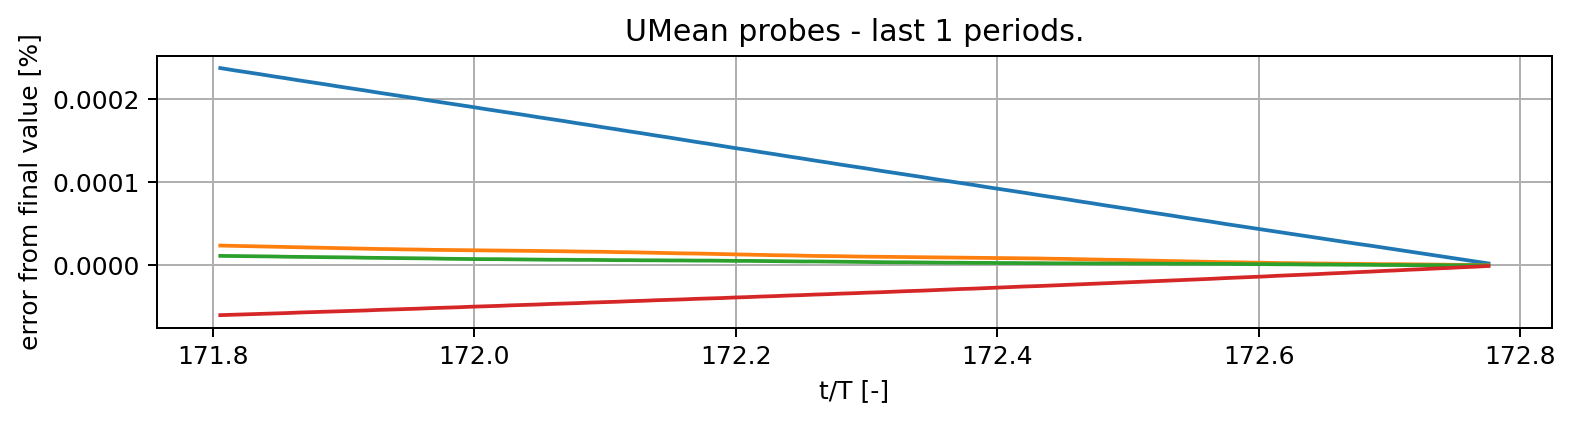

In [8]:
if probes_Stat:
    restartTimesSTD = sorted(os.listdir(pwd+'/postProcessing/probesStat'))
    probes_UPrime2Mean_UMean_path = [pwd+"/postProcessing/probesStat/"+s for s in restartTimesSTD]
    
    # probe names
    probe_names = []
    for probe_id in probe_ids:
        a = linecache.getline(join(probes_UPrime2Mean_UMean_path[0], "UMean"), probe_id+1)
        probe_names.append(a[2:])
    
    # stack probe data for different times
    with open(join(probes_UPrime2Mean_UMean_path[0], "UMean"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
    all_probes = np.array(data)
    for file in probes_UPrime2Mean_UMean_path[1:]:
        with open(join(file, "UMean"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
            all_probes = np.vstack((all_probes,data))
    del data
    
    # remove non unique rows
    _ , index = np.unique(all_probes[:,0], return_index=True,axis=0)
    all_probes_unique = all_probes[index,:]
    initial_size = len(all_probes)
    unique_size = len(all_probes_unique)
    print (" Time series eliminated from",initial_size, "to",unique_size)
    del all_probes
    
    # plot probes
    i_coor = 0                                ## definition of what coordinate I want to print
    fig, ax = plt.subplots()
    plt.title("UMean probes")
    for index, elem in enumerate(probe_ids):
        error = 100*(all_probes_unique[:,1+3*probe_ids[index]+i_coor]-all_probes_unique[-1,1+3*probe_ids[index]+i_coor])/all_probes_unique[-1,1+3*probe_ids[index]+i_coor]
        ax.plot(all_probes_unique[:,0]/period,error,label=probe_names[index])

    legend = ax.legend(loc='upper center', fontsize='x-small',bbox_to_anchor = [0.5,-0.4],ncol=index+1)
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('error from final value [%]')
    plt.grid()
    
    # plot probes zoom in  
    fig, ax = plt.subplots()
    plt.title("UMean probes - last %i periods." %nbLastPeriods)
    for index, elem in enumerate(probe_ids):
        count = 1+3*probe_ids[index]+i_coor
        error = 100*(all_probes_unique[-int(dtPerPeriod*nbLastPeriods):-1,count]-all_probes_unique[-1,count])/all_probes_unique[-1,count]
        ax.plot(all_probes_unique[-int(dtPerPeriod*nbLastPeriods):-1,0]/period,error,label=probe_names[index])
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('error from final value [%]')
    plt.grid()
    
    del all_probes_unique

### 5) Standard deviation of instantaneous velocity

 Time series eliminated from 13095 to 13095


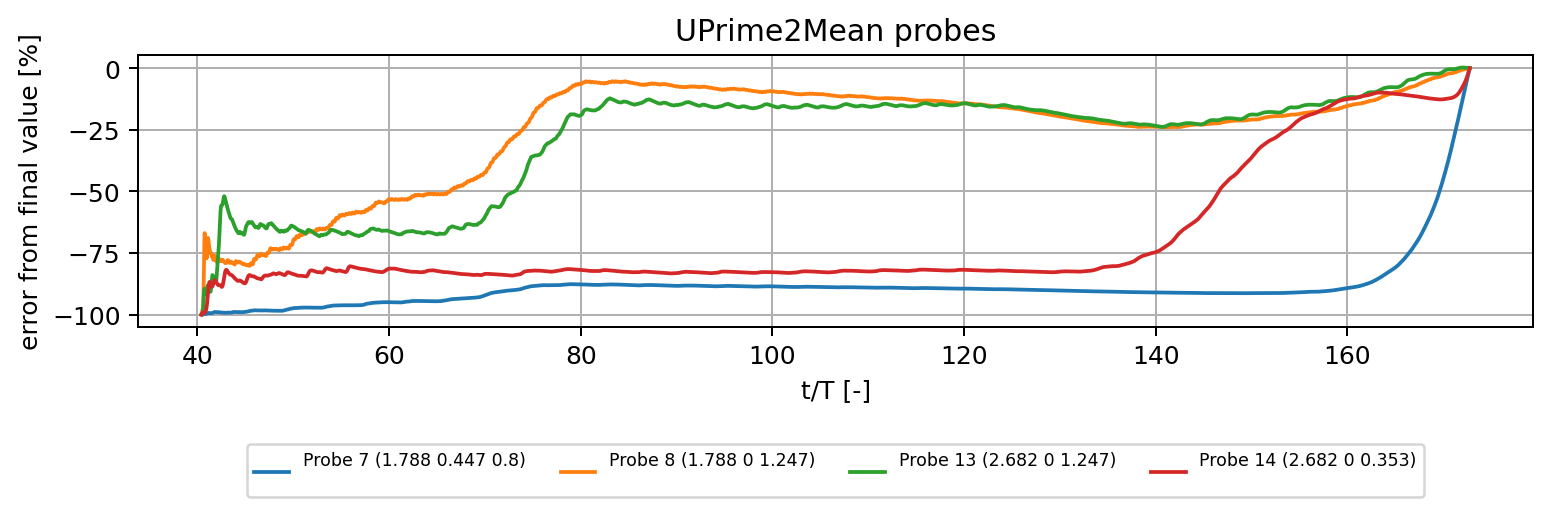

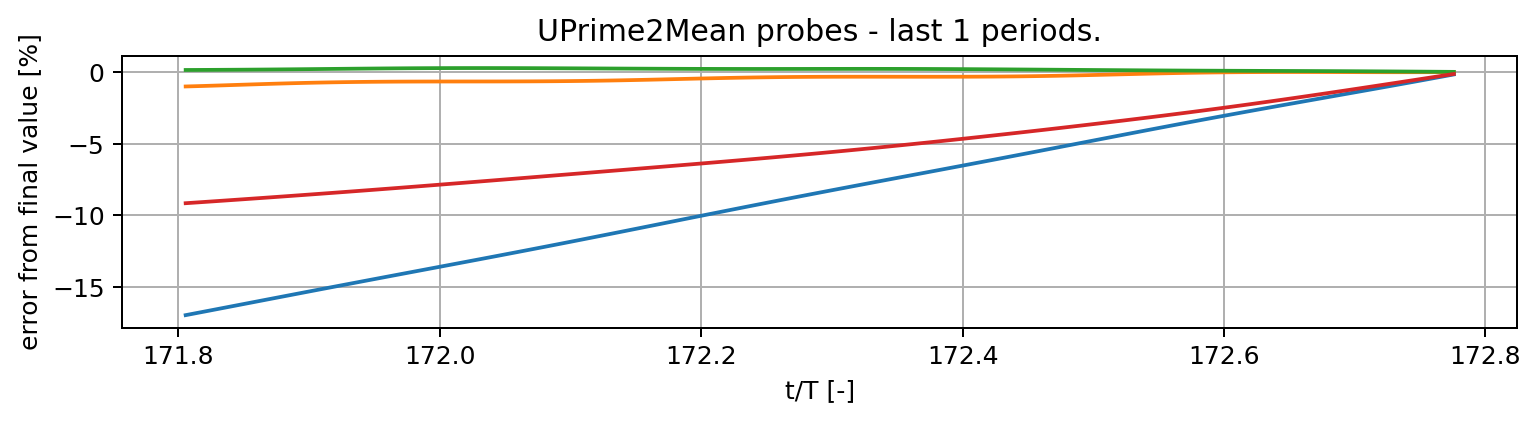

In [10]:
if probes_Stat:
    restartTimesSTD = sorted(os.listdir(pwd+'/postProcessing/probesStat'))
    probes_UPrime2Mean_UMean_path = [pwd+"/postProcessing/probesStat/"+s for s in restartTimesSTD]
     # probe names
    probe_names = []
    for probe_id in probe_ids:
        a = linecache.getline(join(probes_UPrime2Mean_UMean_path[0], "UPrime2Mean"), probe_id+1)
        probe_names.append(a[2:])
    # stack probe data for different times
    with open(join(probes_UPrime2Mean_UMean_path[0], "UPrime2Mean"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
    all_probes = np.array(data)
    for file in probes_UPrime2Mean_UMean_path[1:]:
        with open(join(file, "UPrime2Mean"), "r") as pfile:
            data = sub("[()]", "", pfile.read())
            data = read_csv(StringIO(data), header=None, comment="#", delim_whitespace=True)
            all_probes = np.vstack((all_probes,data))
    del data

    # remove non unique rows
    _ , index = np.unique(all_probes[:,0], return_index=True,axis=0)
    all_probes_unique = all_probes[index,:]
    initial_size = len(all_probes)
    unique_size = len(all_probes_unique)
    del all_probes
    print (" Time series eliminated from",initial_size, "to",unique_size)

    # plot probes
    i_coor = 0            ## definition of what coordinate I want to print
    fig, ax = plt.subplots()
    plt.title("UPrime2Mean probes")
    for index, elem in enumerate(probe_ids):
        count = 1+6*probe_ids[index]+i_coor
        error = 100*(all_probes_unique[:,count]-all_probes_unique[-1,count])/all_probes_unique[-1,count]
        ax.plot(all_probes_unique[:,0]/period,error,label=probe_names[index])
    legend = ax.legend(loc='upper center', fontsize='x-small',bbox_to_anchor = [0.5,-0.4],ncol=index+1)
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('error from final value [%]')
    plt.grid()
    
    # plot probes zoom in
    fig, ax = plt.subplots()
    plt.title("UPrime2Mean probes - last %i periods." %nbLastPeriods)
    for index, elem in enumerate(probe_ids):
        count = 1+6*probe_ids[index]+i_coor
        error = 100*(all_probes_unique[-int(dtPerPeriod*nbLastPeriods):-1,count]-all_probes_unique[-1,count])/all_probes_unique[-1,count]
        ax.plot(all_probes_unique[-int(dtPerPeriod*nbLastPeriods):-1,0]/period,error,label=probe_names[index])
    fig.set_size_inches(10, 2)
    plt.xlabel('t/T [-]')
    plt.ylabel('error from final value [%]')
    plt.grid()
    
    del all_probes_unique

# Rotor Information
### 1) Power and thrust coefficients

In [11]:
if turbineOutput:
    avg_power = power_lastPer.mean(0)[3]
    avg_thrust = thrust_lastPer.mean(0)[3]
    A = np.pi*D**2/4  
    cp = avg_power/(0.5*rho*A*U**3)
    ct = avg_thrust/(0.5*rho*A*U**2)
    
    # write table
    data = [["Power Coefficient",float("{0:.3f}".format(cp))],["Thrust Coefficient",float("{0:.3f}".format(ct))]]
    display(HTML(
       '<table><tr>{}</tr></table>'.format(
           '</tr><tr>'.join(
               '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
           )
    ))

Power Coefficient,0.608
Thrust Coefficient,0.931


### 2) Spanwise distributions

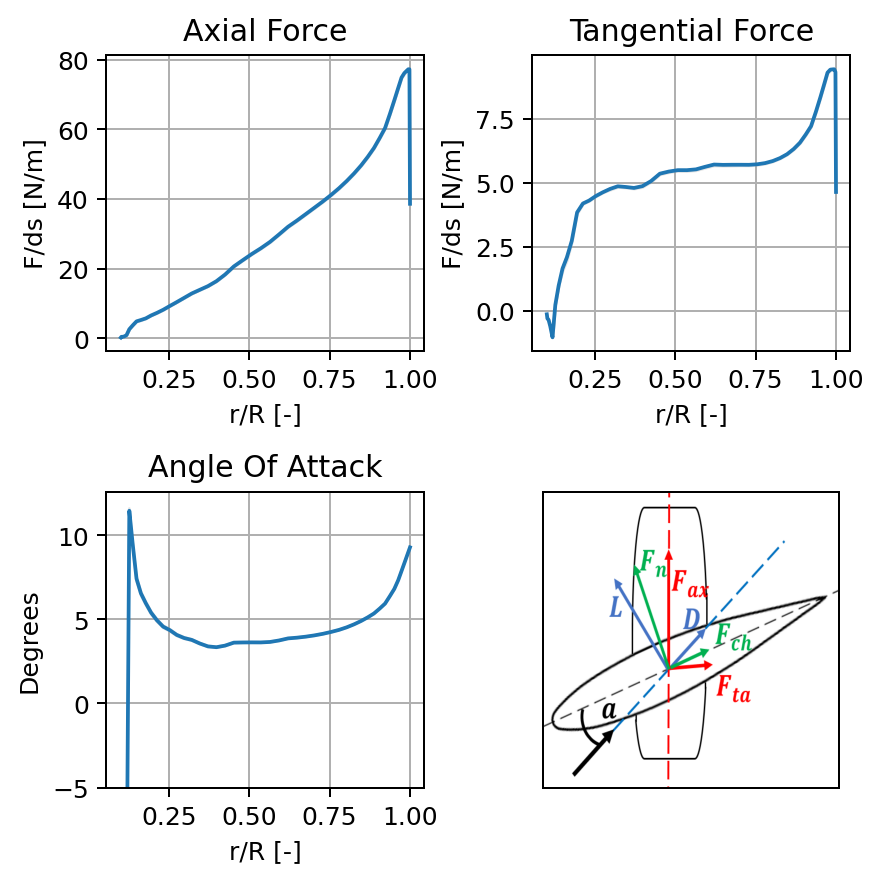

In [12]:
if turbineOutput:
    
    # load radius
    radiusC = np.genfromtxt(join(turbine_output_path[-1],"radiusC"))
    radiusC = radiusC[0,2:radiusC.shape[1]] 
    nbColloc = radiusC.shape[0]
    
    # calculate ds
    ds = np.zeros(nbColloc);
    ds[0] = radiusC[1]-radiusC[0];
    ds[-1] = radiusC[-1]-radiusC[-2];
    for index, elem in enumerate(radiusC):
        if (index>=1 and index < nbColloc-1):
            ds[index] = (radiusC[index+1]-radiusC[index-1])/2
    
    # nondimensionalize radius
    radiusC = radiusC/(D/2)
    
    # load force files 
    filename = ["axialForce","tangentialForce", "chordwiseForce", "normalForce","alphaC"]
    all_forces = []
    min_forces = []
    max_forces = []
    for file in filename:
        force = np.genfromtxt(join(turbine_output_path[-1],file))
        force = force[0:-1:3,4:force.shape[1]] 
        forceLast = force[-int(dtPerPeriod*nbLastPeriods):-1]
        all_forces.append(forceLast.mean(0))
        min_forces.append(forceLast.min(0))
        max_forces.append(forceLast.max(0))
        
    # plot forces, aoa
    fig, axs = plt.subplots(2, 2,figsize=(5,5))
    axs[0,0].plot(radiusC,all_forces[0]/ds)
    axs[0,0].fill_between(radiusC, min_forces[0]/ds, max_forces[0]/ds,color='gray',alpha=0.2)
    axs[0,0].set_title("Axial Force")
    axs[0,0].set_xlabel("r/R [-]")
    axs[0,0].set_ylabel("F/ds [N/m]")
    axs[0,0].grid()
    axs[0,1].plot(radiusC,all_forces[1]/ds)
    axs[0,1].fill_between(radiusC, min_forces[1]/ds, max_forces[1]/ds,color='gray',alpha=0.2)
    axs[0,1].set_title("Tangential Force")
    axs[0,1].set_xlabel("r/R [-]")
    axs[0,1].set_ylabel("F/ds [N/m]")
    axs[0,1].grid()
    axs[1,0].plot(radiusC,all_forces[4])
    axs[1,0].fill_between(radiusC, min_forces[4], max_forces[4],color='gray',alpha=0.2)
    axs[1,0].set_title("Angle Of Attack")
    axs[1,0].set_xlabel("r/R [-]")
    axs[1,0].set_ylabel("Degrees")
    axs[1,0].set_ylim(-5,all_forces[4].max()*1.1)
    axs[1,0].grid()
    im = image.imread('/home/ball5392/Codes/AL_POST_PROCESS/forces.png')
    axs[1,1].imshow(im, extent=(0, 200, 0, 200), aspect=1,cmap="plasma")
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])
    fig.tight_layout()

# Power Spectral Density

dt [s],0.000468
T [s],0.0463
T/dt [-],98.93162393162393
f_min [Hz],0.191
f_max [Hz],2136.752
f_3P [Hz],64.795
n_samples [-],11158


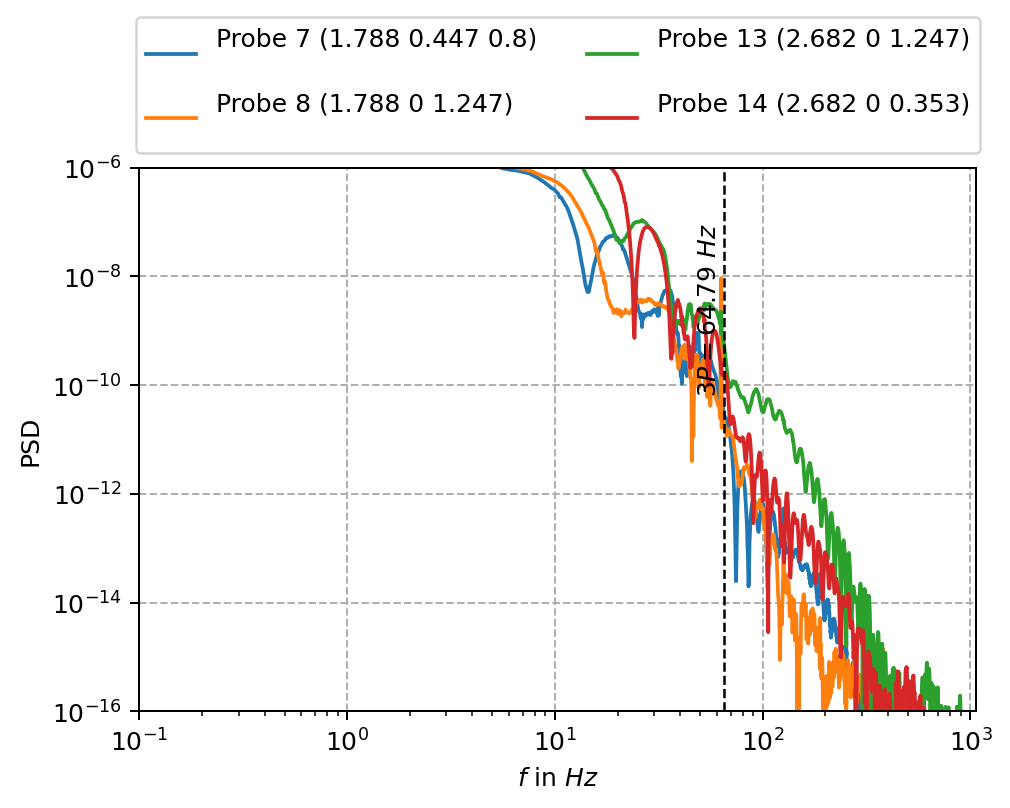

In [24]:
if probes_Inst:
    # sampling frequency
    fs = 1.0 / dt
    fbp = 3/period

    # skip initial transient 
    fromPeriod = 60;                      # define the period to start averaging from
    fromID = int(fromPeriod*dtPerPeriod);
    sampling_period = all_u_inst[-1,0]-all_u_inst[fromID,0]
    fmin = 1/sampling_period
    n_samples = len(all_u_inst[fromID:-1])

    # write talbe
    data = [["dt [s]",dt],
            ["T [s]",period],
            ["T/dt [-]",period/dt],
            ["f_min [Hz]",float("{0:.3f}".format(fmin))],
            ["f_max [Hz]",float("{0:.3f}".format(fs))],
            ["f_3P [Hz]",float("{0:.3f}".format(fbp))],
            ["n_samples [-]",n_samples]
           ]
    display(HTML(
       '<table><tr>{}</tr></table>'.format(
           '</tr><tr>'.join(
               '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
           )
    ))
    nwin, npad = 1, 1
    colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:grey","tab:olive"]
    icoor = 0
    for index, elem in enumerate(probe_ids):
        f, a = welch(all_u_inst[:,1+3*probe_ids[index]+i_coor], fs=fs, nperseg=int(n_samples/nwin), nfft=npad*n_samples)
        plt.plot(f, a, ls="-", label=probe_names[index],c = colors[index])
        top_i = a.argmax()
        plt.axvline(f[top_i], ls="--", lw=1, c=colors[index])
       # plt.text(0.85*f[top_i], 1e-7, r"$f={:2.2f}\ Hz$".format(f[top_i]), rotation=90, va="top", ha="center")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(1e-01, 0.5*fs)
        plt.ylim(1e-16,1e-6)                                # ylimits
        plt.xlabel(r"$f$ in $Hz$")
        plt.ylabel("PSD")
        plt.legend(bbox_to_anchor=[0.5, 1.3], ncol=2, loc="upper center")
        plt.grid(ls="--")

    plt.axvline(fbp, ls="--", lw=1, c="k")
    plt.text(0.85*fbp, 1e-7, r"$3P={:2.2f}\ Hz$".format(fbp), rotation=90, va="top", ha="center")
    plt.show()

In [11]:
# # plot probes
# i_coor = 0;  ## definition of what coordinate I want to print
# fig, axs = plt.subplots(len(probe_ids), 1,figsize=(10,10))
# fig.suptitle("Instantaneous velocity probes")
# for index, elem in enumerate(probe_ids):
#     axs[index].plot(all_probes_unique[:,0]/period,all_probes_unique[:,1+3*probe_ids[index]+i_coor],label=probe_names[index])
#     axs[index].set_xlabel('t/T [-]')
#     axs[index].set_ylabel('u')
#     axs[index].legend(bbox_to_anchor=[1., 0.75], loc="right")
#     axs[index].grid()
    
# fig.tight_layout()

# Write Files

In [12]:
#with open('ALL_PROBES.txt', 'w') as f:
#    csv.writer(f, delimiter=' ').writerows(all_probes)